In [2]:
import os, sys
import numpy as np
import h5py
import tensorly as tl

/Users/wu-jung/miniconda3/envs/deeplearning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using numpy backend.


In [3]:
# Load PCP-cleaned MVBS data
MVBS_path = '/Users/wu-jung/code_git/ooi_sonar/sample_data/'
MVBS_fname = '20150817-20151017_MVBS_PCPcleaned.h5'

import h5py
f = h5py.File(os.path.join(MVBS_path,MVBS_fname),'r')

In [4]:
# Load low-rank data
L = np.array(f['L'])
L_sep = np.array(f['L_sep'])
L_plot = np.array(f['L_plot'])
depth_bin_size = np.array(f['depth_bin_size'])
ping_per_day_mvbs = np.array(f['ping_per_day_mvbs'])
ping_time = np.array(f['ping_time'])
f.close()
depth_bin_num = 37;

In [5]:
L.shape

(62, 15984)

In [6]:
L_sep.shape

(3, 62, 37, 144)

In [7]:
import matplotlib.pyplot as plt

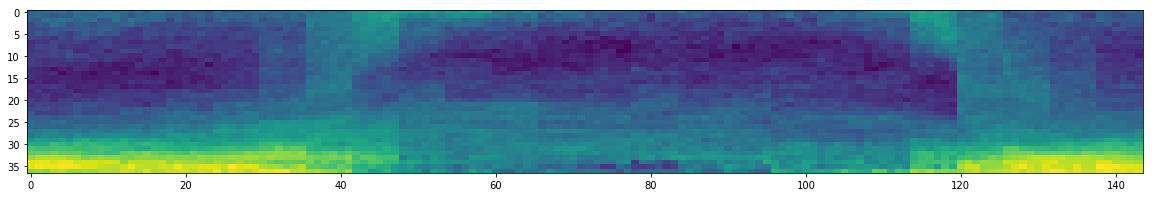

In [8]:
fig = plt.figure(figsize=(20,3))
plt.imshow(L_sep[0,0,:,:].squeeze(),aspect='auto')

In [9]:
L_plot.shape

(3, 37, 8928)

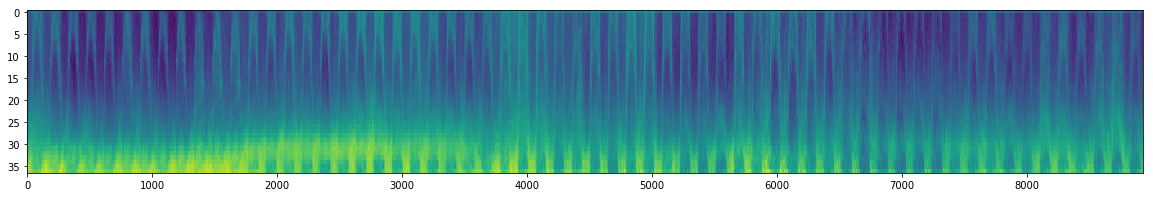

In [10]:
fig = plt.figure(figsize=(20,3))
plt.imshow(L_plot[2,:,:].squeeze(),aspect='auto')

In [11]:
ping_mean_num = 6
L_sep_reduce = np.empty((L_sep.shape[0],L_sep.shape[1],L_sep.shape[2],int(L_sep.shape[3]/ping_mean_num)))
for hr in range(24):
    L_sep_reduce[:,:,:,hr] = np.mean(L_sep[:,:,:,hr*ping_mean_num+np.arange(ping_mean_num)])

In [12]:
L_sep_reduce.shape

(3, 62, 37, 24)

In [13]:
sonar_tensor = L_sep[0,:,:,:]

In [14]:
sonar_tensor.shape

(62, 37, 144)

In [15]:
# kruskal decomposition is parafac in tensorly
from tensorly.decomposition import parafac

In [16]:
kruskal_rank = 5
factors_kruskal = parafac(sonar_tensor, rank = kruskal_rank)

In [17]:
[print(f.shape) for f in factors_kruskal]

(62, 5)
(37, 5)
(144, 5)


[None, None, None]

In [18]:
full_tensor = tl.kruskal_to_tensor(factors_kruskal)

In [19]:
full_tensor.shape

(62, 37, 144)

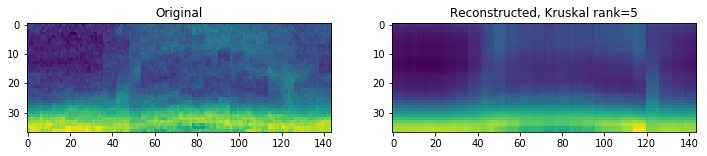

In [20]:
fig,ax = plt.subplots(1,2,figsize=(12,2))
ax[0].imshow(sonar_tensor[10,:,:],aspect='auto')
ax[0].set_title('Original')
ax[1].imshow(full_tensor[10,:,:],aspect='auto')
ax[1].set_title('Reconstructed, Kruskal rank=%d'%kruskal_rank)
plt.show()

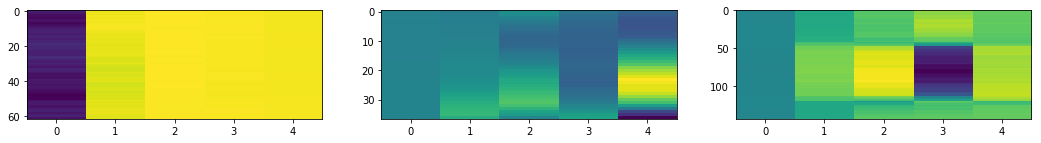

In [21]:
fig,ax = plt.subplots(1,3,figsize=(18,2))
for ii,ik in zip(range(len(factors_kruskal)),factors_kruskal):
    ax[ii].imshow(ik,aspect='auto')

In [22]:
sonar_tensor[0:5,:,:].shape

(5, 37, 144)

In [23]:
stl = tl.tensor(sonar_tensor[0:10,:,:])
stl_recons = tl.tensor(full_tensor[0:10,:,:])

In [24]:
tl.unfold(stl,mode=1).shape

(37, 1440)

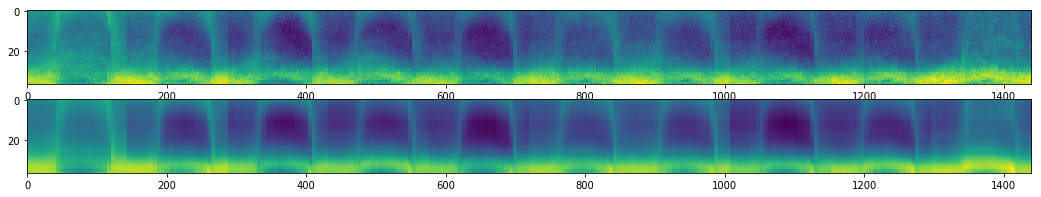

In [25]:
fig = plt.figure(figsize=(18,3))
fig.add_subplot(211)
plt.imshow(tl.unfold(stl,mode=1), aspect='auto')
fig.add_subplot(212)
plt.imshow(tl.unfold(stl_recons,mode=1), aspect='auto')

In [26]:
from tensorly.tenalg import kronecker, khatri_rao

In [27]:
kh12 = khatri_rao((factors_kruskal[1],factors_kruskal[2]))
kh01 = khatri_rao((factors_kruskal[0],factors_kruskal[1]))
kh02 = khatri_rao((factors_kruskal[0],factors_kruskal[2]))

In [28]:
kh12.shape

(5328, 5)

In [29]:
(factors_kruskal[0].shape, factors_kruskal[1].shape, factors_kruskal[2].shape)

((62, 5), (37, 5), (144, 5))

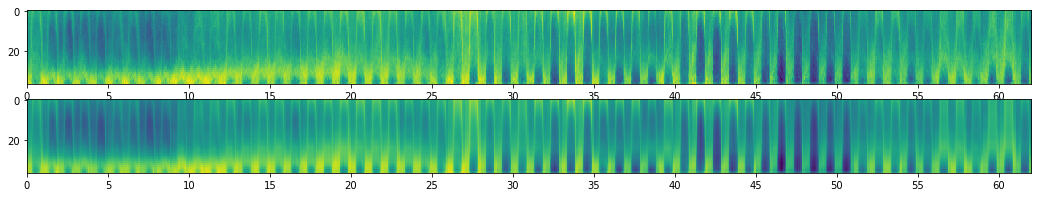

In [30]:
fig = plt.figure(figsize=(18,3))
fig.add_subplot(211)
plt.imshow(tl.unfold(tl.tensor(sonar_tensor),mode=1), aspect='auto')
plt.xticks(range(0,65*144,144*5), range(0,65,5))
fig.add_subplot(212)
plt.imshow(tl.unfold(tl.tensor(full_tensor),mode=1), aspect='auto')
plt.xticks(range(0,65*144,144*5), range(0,65,5))
plt.show()

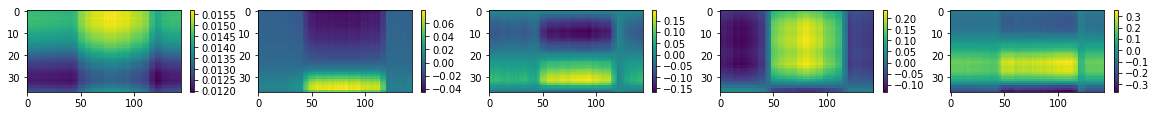

In [31]:
fac_num = 5
fig = plt.figure(figsize=(20,1.5))
for fac in range(fac_num):
    fig.add_subplot(1,fac_num,fac+1)
    plt.imshow(kh12[:,fac].reshape(37,144),aspect='auto')
    plt.colorbar()

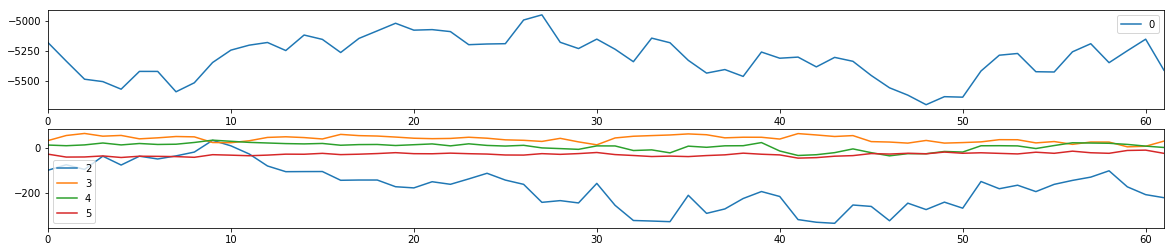

In [32]:
fig = plt.figure(figsize=(20,4))
fig.add_subplot(211)
plt.plot(factors_kruskal[0][:,0],label='%d'% 0)
plt.xlim(0,61)
plt.legend()
fig.add_subplot(212)
for fac in range(1,fac_num):
    plt.plot(factors_kruskal[0][:,fac],label='%d'% (fac+1))
    plt.xlim(0,61)
plt.legend()
plt.show()

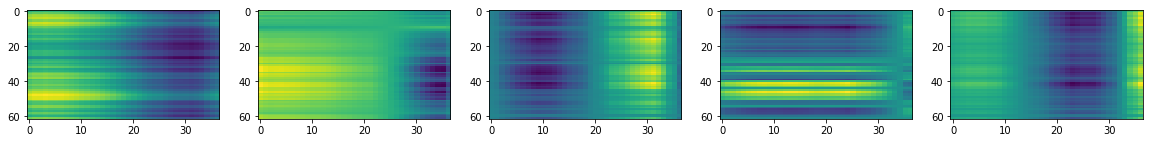

In [33]:
fac_num = 5
fig = plt.figure(figsize=(20,2))
for fac in range(fac_num):
    fig.add_subplot(1,fac_num,fac+1)
    plt.imshow(kh01[:,fac].reshape(62,37),aspect='auto')

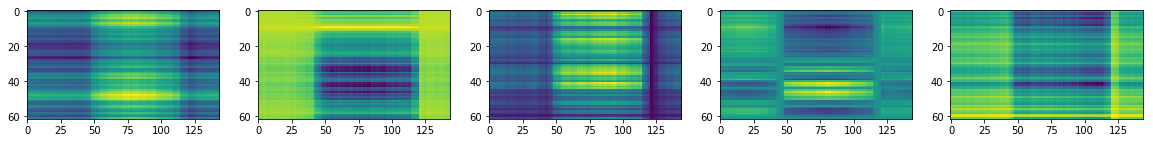

In [34]:
fac_num = 5
fig = plt.figure(figsize=(20,2))
for fac in range(fac_num):
    fig.add_subplot(1,fac_num,fac+1)
    plt.imshow(kh02[:,fac].reshape(62,144),aspect='auto')

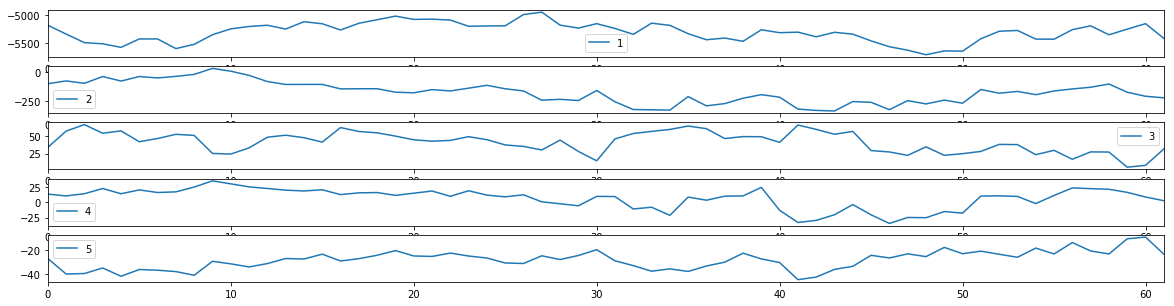

In [60]:
fig = plt.figure(figsize=(20,5))
for fac in range(fac_num):
    fig.add_subplot(fac_num,1,fac+1)
    plt.plot(factors_kruskal[0][:,fac],label='%d'% (fac+1))
    plt.xlim(0,61)
    plt.legend()
plt.show()

In [112]:
k = factors_kruskal[0].T
k.shape

(5, 62)

In [113]:
k.min(axis=1).shape

(5,)

In [114]:
k_norm = k.T-k.min(axis=1)
k_norm = k_norm/k_norm.max(axis=0)
k_norm.shape

(62, 5)

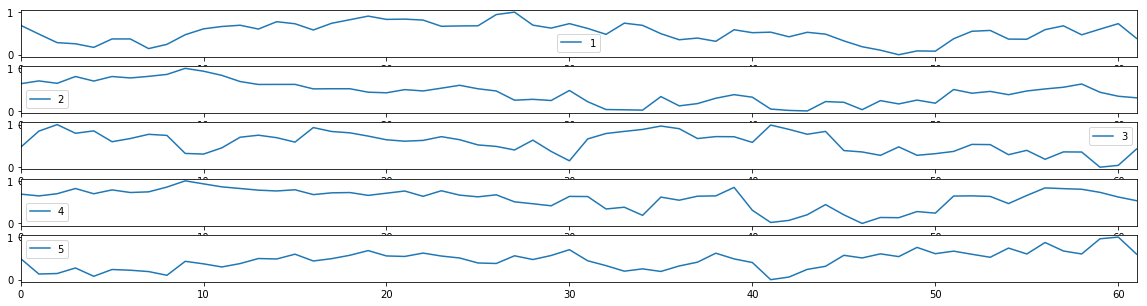

In [115]:
fig = plt.figure(figsize=(20,5))
for fac in range(k_norm.shape[1]):
    fig.add_subplot(fac_num,1,fac+1)
    plt.plot(k_norm[:,fac],label='%d'% (fac+1))
    plt.xlim(0,61)
    plt.legend()
plt.show()

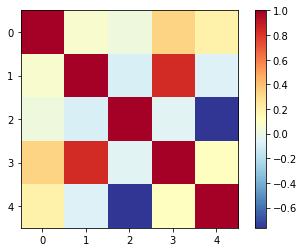

In [116]:
plt.imshow(np.corrcoef(k_norm.T),cmap='RdYlBu_r')
plt.colorbar()
plt.show()

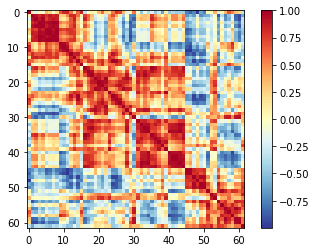

In [117]:
plt.imshow(np.corrcoef(k_norm),cmap='RdYlBu_r')
plt.colorbar()
plt.show()

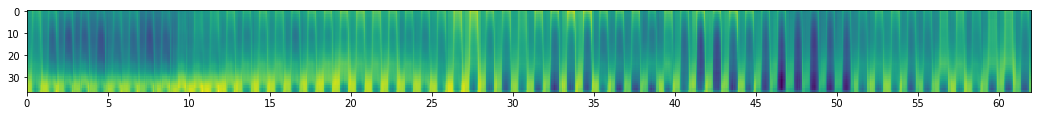

In [119]:
fig = plt.figure(figsize=(18,1.5))
plt.imshow(tl.unfold(tl.tensor(full_tensor),mode=1), aspect='auto')
plt.xticks(range(0,62*144,144*5), range(0,62,5))
plt.show()

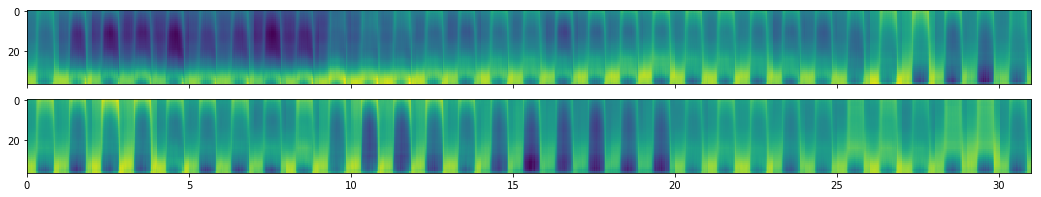

In [118]:
fig,ax = plt.subplots(2,1,figsize=(18,3),sharex=True)
ax[0].imshow(tl.unfold(tl.tensor(full_tensor[:31,:]),mode=1), aspect='auto')
plt.xticks(range(0,31*144,144*5), range(0,31,5))
ax[1].imshow(tl.unfold(tl.tensor(full_tensor[31:,:]),mode=1), aspect='auto')
plt.xticks(range(0,31*144,144*5), range(0,31,5))
plt.show()

### Non-negative parafac

In [62]:
# non-negative kruskal decomposition is parafac in tensorly
from tensorly.decomposition import non_negative_parafac

In [36]:
kruskal_nonneg_rank = 5
factors_kruskal_noneg = non_negative_parafac(sonar_tensor-sonar_tensor.min(), rank = kruskal_nonneg_rank)

In [37]:
[print(f.shape) for f in factors_kruskal_noneg]

(62, 5)
(37, 5)
(144, 5)


[None, None, None]

In [38]:
full_tensor_nonneg = tl.kruskal_to_tensor(factors_kruskal_noneg)

In [39]:
(sonar_tensor.max(),full_tensor.max(),full_tensor_nonneg.max()+sonar_tensor.min())

(-57.67213720366907, -57.693429184966845, -53.03599379137503)

In [40]:
(sonar_tensor.min(),full_tensor.min(),full_tensor_nonneg.min()+sonar_tensor.min())

(-96.51878235649372, -94.06375555097264, -91.6198412066534)

In [41]:
(sonar_tensor.max()-sonar_tensor.min(),
 full_tensor.max()-full_tensor.min(),
 full_tensor_nonneg.max()-full_tensor_nonneg.min())

(38.84664515282465, 36.3703263660058, 38.583847415278385)

### Compare regular parafac and non-negative parafac

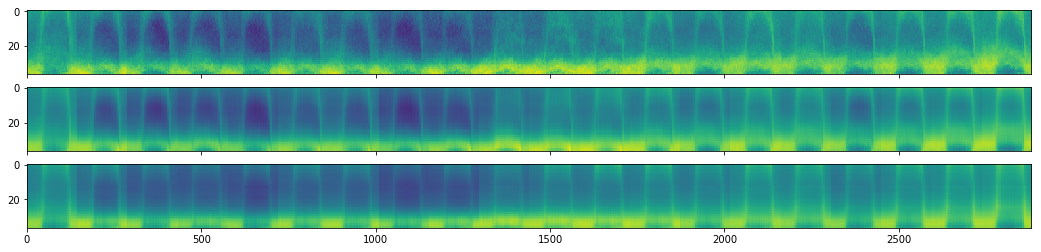

In [51]:
fig,ax = plt.subplots(3,1,figsize=(18,4),sharex=True)
ax[0].imshow(tl.unfold(tl.tensor(sonar_tensor[0:20,::]),mode=1), aspect='auto',
          vmax=-57, vmin=-90)
ax[1].imshow(tl.unfold(tl.tensor(full_tensor[0:20,::]),mode=1), aspect='auto',
           vmax=-57, vmin=-90)
ax[2].imshow(tl.unfold(tl.tensor(full_tensor_nonneg[0:20,::]),mode=1)+sonar_tensor.min(), aspect='auto',
           vmax=-57, vmin=-90)
plt.show()

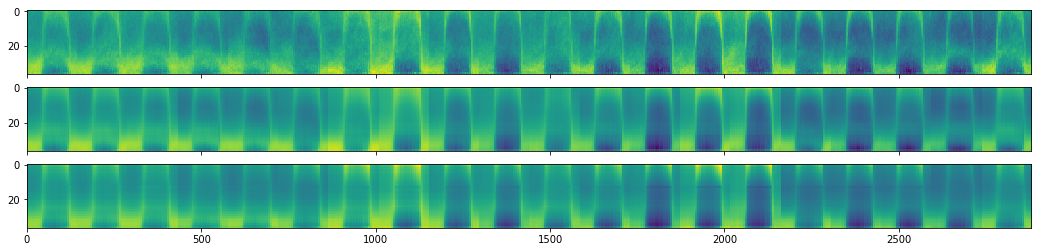

In [52]:
fig,ax = plt.subplots(3,1,figsize=(18,4),sharex=True)
ax[0].imshow(tl.unfold(tl.tensor(sonar_tensor[20:40,::]),mode=1), aspect='auto',
          vmax=-57, vmin=-90)
ax[1].imshow(tl.unfold(tl.tensor(full_tensor[20:40,::]),mode=1), aspect='auto',
           vmax=-57, vmin=-90)
ax[2].imshow(tl.unfold(tl.tensor(full_tensor_nonneg[20:40,::]),mode=1)+sonar_tensor.min(), aspect='auto',
           vmax=-57, vmin=-90)
plt.show()

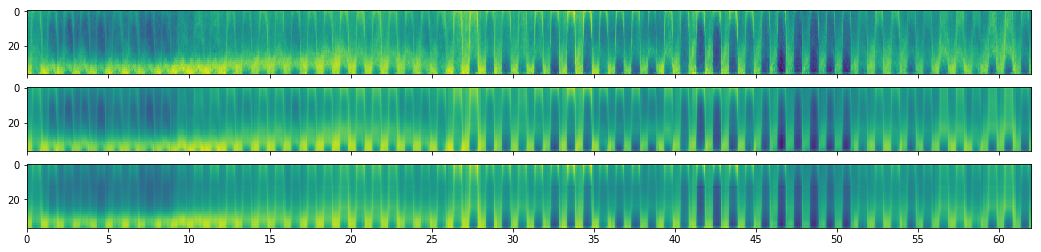

In [43]:
fig,ax = plt.subplots(3,1,figsize=(18,4),sharex=True)
ax[0].imshow(tl.unfold(tl.tensor(sonar_tensor),mode=1), aspect='auto',
          vmax=-57, vmin=-96)
plt.xticks(range(0,65*144,144*5), range(0,65,5))
ax[1].imshow(tl.unfold(tl.tensor(full_tensor),mode=1), aspect='auto',
          vmax=-57, vmin=-96)
plt.xticks(range(0,65*144,144*5), range(0,65,5))
ax[2].imshow(tl.unfold(tl.tensor(full_tensor_nonneg),mode=1)+sonar_tensor.min(), aspect='auto',
          vmax=-57, vmin=-96)
plt.xticks(range(0,65*144,144*5), range(0,65,5))
plt.show()

### Check how each factor looks like and their activation

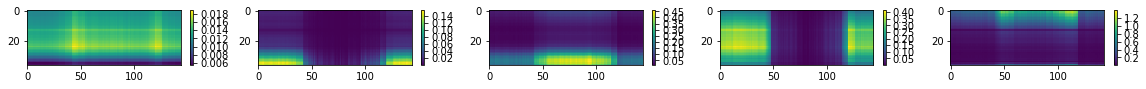

In [179]:
kh12_nonneg = khatri_rao((factors_kruskal_noneg[1],factors_kruskal_noneg[2]))
kh01_nonneg = khatri_rao((factors_kruskal_noneg[0],factors_kruskal_noneg[1]))
kh02_nonneg = khatri_rao((factors_kruskal_noneg[0],factors_kruskal_noneg[2]))

fac_num = kruskal_nonneg_rank
fig = plt.figure(figsize=(20,1))
for fac in range(fac_num):
    fig.add_subplot(1,fac_num,fac+1)
    plt.imshow(kh12_nonneg[:,fac].reshape(37,144),aspect='auto')
    plt.colorbar()

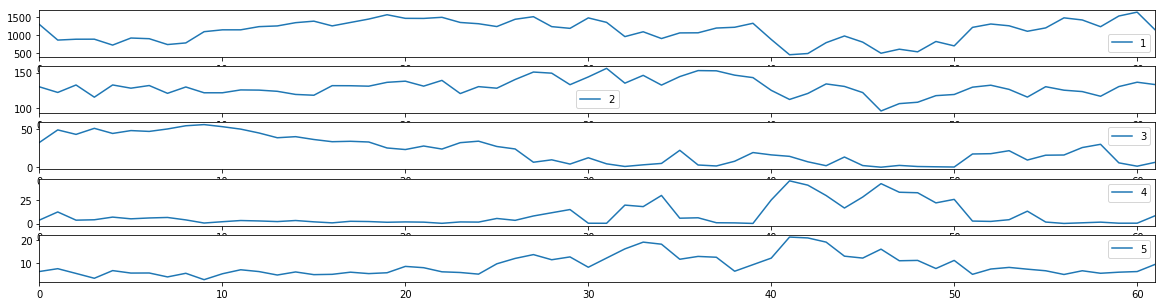

In [180]:
fig = plt.figure(figsize=(20,5))
for fac in range(fac_num):
    fig.add_subplot(fac_num,1,fac+1)
    plt.plot(factors_kruskal_noneg[0][:,fac],label='%d'% (fac+1))
    plt.xlim(0,61)
    plt.legend()
plt.show()

In [181]:
k = factors_kruskal_noneg[0].T
k_norm = k.T-k.min(axis=1)
k_norm = k_norm/k_norm.max(axis=0)
k_norm.shape

(62, 5)

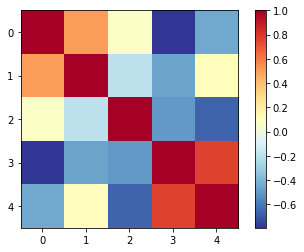

In [185]:
k = factors_kruskal_noneg[0]
plt.imshow(np.corrcoef(k_norm.T),cmap='RdYlBu_r')
plt.colorbar()
plt.show()

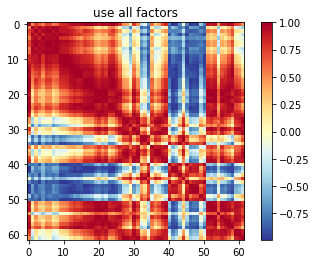

In [186]:
plt.imshow(np.corrcoef(k_norm),cmap='RdYlBu_r')
plt.colorbar()
plt.title('use all factors')
plt.show()

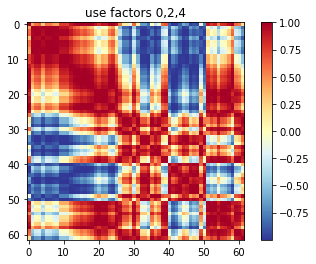

In [187]:
plt.imshow(np.corrcoef(k_norm[:,[0,2,4]]),cmap='RdYlBu_r')
plt.colorbar()
plt.title('use factors 0,2,4')
plt.show()

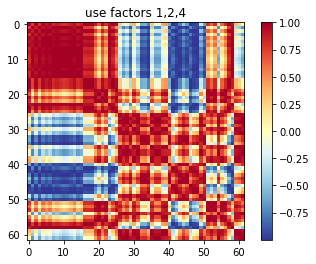

In [188]:
plt.imshow(np.corrcoef(k_norm[:,[1,2,4]]),cmap='RdYlBu_r')
plt.colorbar()
plt.title('use factors 1,2,4')
plt.show()

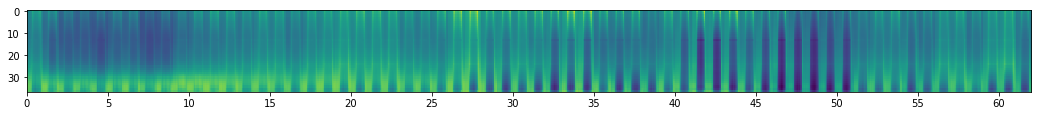

In [120]:
fig = plt.figure(figsize=(18,1.5))
plt.imshow(tl.unfold(tl.tensor(full_tensor_nonneg),mode=1), aspect='auto')
plt.xticks(range(0,62*144,144*5), range(0,62,5))
plt.show()

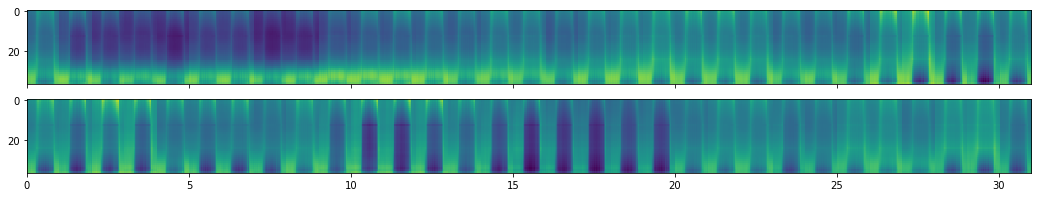

In [121]:
fig,ax = plt.subplots(2,1,figsize=(18,3),sharex=True)
ax[0].imshow(tl.unfold(tl.tensor(full_tensor_nonneg[:31,:]),mode=1), aspect='auto')
plt.xticks(range(0,31*144,144*5), range(0,31,5))
ax[1].imshow(tl.unfold(tl.tensor(full_tensor_nonneg[31:,:]),mode=1), aspect='auto')
plt.xticks(range(0,31*144,144*5), range(0,31,5))
plt.show()

### Try reconstruction and check sparse component

In [129]:
# Reconstruct a particular day
recons_day = 20

In [125]:
kh12_nonneg.shape

(5328, 5)

In [127]:
factors_kruskal_noneg[0].shape

(62, 5)

In [140]:
recons_mtx = (factors_kruskal_noneg[0][recons_day,:]*kh12_nonneg).T
recons_vec = np.sum(recons_mtx,axis=0)
recons_vec.shape

(5328,)

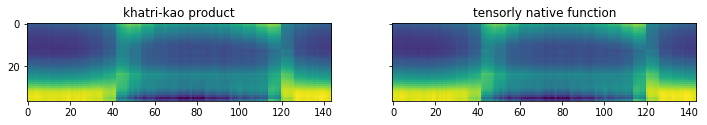

In [162]:
# Check if reconstruction is correct
fig,ax = plt.subplots(1,2,figsize=(12,2),sharey=True)
ax[0].imshow(recons_vec.reshape((37,144)))
ax[0].set_title('khatri-kao product')
ax[1].imshow(full_tensor_nonneg[recons_day,:])
ax[1].set_title('tensorly native function')
plt.show()

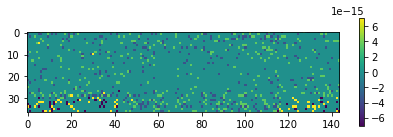

In [159]:
# Check errors in reconstruction via two different routes
fig = plt.figure(figsize=(7,2))
plt.imshow(recons_vec.reshape((37,144))-full_tensor_nonneg[recons_day,:])
plt.colorbar()
plt.show()

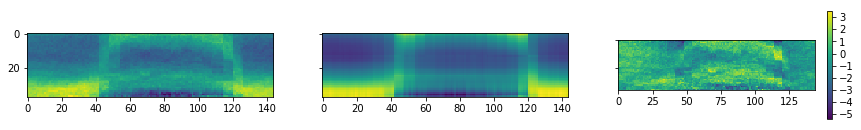

In [171]:
# Check low-rank and sparse component
recons_day = 20
fig,ax = plt.subplots(1,3,figsize=(15,2),sharey=True)
ax[0].imshow(sonar_tensor[recons_day,:,:])
ax[1].imshow(full_tensor_nonneg[recons_day,:]+sonar_tensor.min())
im2 = ax[2].imshow(sonar_tensor[recons_day,:,:]-full_tensor_nonneg[recons_day,:]-sonar_tensor.min())
plt.colorbar(im2)
plt.show()

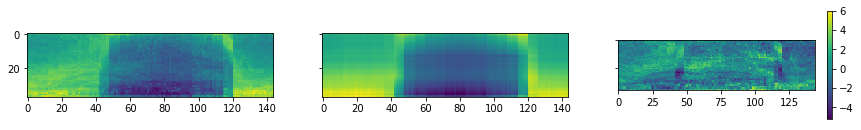

In [177]:
# Check low-rank and sparse component
recons_day = 45
fig,ax = plt.subplots(1,3,figsize=(15,2),sharey=True)
ax[0].imshow(sonar_tensor[recons_day,:,:])
ax[1].imshow(full_tensor_nonneg[recons_day,:]+sonar_tensor.min())
im2 = ax[2].imshow(sonar_tensor[recons_day,:,:]-full_tensor_nonneg[recons_day,:]-sonar_tensor.min())
plt.colorbar(im2)
plt.show()

## Can we select only one from each set of similar components and check confusion matrix?

In [199]:
# Set which day
recons_day = 20

# Use all factors
recons_mtx = (factors_kruskal_noneg[0][recons_day,:]*kh12_nonneg).T
recons_vec = np.sum(recons_mtx,axis=0)
# recons_vec.shape

# Use factors [0,2,4]
recons_mtx_024 = (factors_kruskal_noneg[0][recons_day,[0,2,4]]*kh12_nonneg[:,[0,2,4]]).T
recons_vec_024 = np.sum(recons_mtx_024,axis=0)
# recons_vec_024.shape

# Use factors [1,2,4]
recons_mtx_124 = (factors_kruskal_noneg[0][recons_day,[1,2,4]]*kh12_nonneg[:,[1,2,4]]).T
recons_vec_124 = np.sum(recons_mtx_124,axis=0)

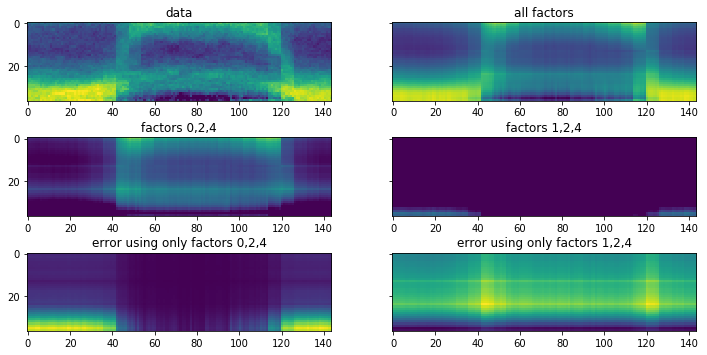

In [204]:
# Check low-rank and sparse component
fig,ax = plt.subplots(3,2,figsize=(12,6),sharey=True)
ax[0,0].imshow(sonar_tensor[recons_day,:,:],vmin=-76,vmax=-61)
ax[0,0].set_title('data')
ax[0,1].imshow(full_tensor_nonneg[recons_day,:]+sonar_tensor.min(),vmin=-76,vmax=-61)
ax[0,1].set_title('all factors')
ax[1,0].imshow(recons_vec_024.reshape((37,144))+sonar_tensor.min(),vmin=-76,vmax=-61)
ax[1,0].set_title('factors 0,2,4')
ax[1,1].imshow(recons_vec_124.reshape((37,144))+sonar_tensor.min(),vmin=-76,vmax=-61)
ax[1,1].set_title('factors 1,2,4')
ax[2,0].imshow(full_tensor_nonneg[recons_day,:]-recons_vec_024.reshape((37,144)))
ax[2,0].set_title('error using only factors 0,2,4')
ax[2,1].imshow(full_tensor_nonneg[recons_day,:]-recons_vec_124.reshape((37,144)))
ax[2,1].set_title('error using only factors 1,2,4')
plt.show()

In [202]:
a = full_tensor_nonneg[recons_day,:]+sonar_tensor.min()

In [203]:
(a.max(), a.min())

(-61.48585973663351, -76.23942359393027)

In [205]:
# Set which day
recons_day = 0

# Use all factors
recons_mtx = (factors_kruskal_noneg[0][recons_day,:]*kh12_nonneg).T
recons_vec = np.sum(recons_mtx,axis=0)
# recons_vec.shape

# Use factors [0,2,4]
recons_mtx_024 = (factors_kruskal_noneg[0][recons_day,[0,2,4]]*kh12_nonneg[:,[0,2,4]]).T
recons_vec_024 = np.sum(recons_mtx_024,axis=0)
# recons_vec_024.shape

# Use factors [1,2,4]
recons_mtx_124 = (factors_kruskal_noneg[0][recons_day,[1,2,4]]*kh12_nonneg[:,[1,2,4]]).T
recons_vec_124 = np.sum(recons_mtx_124,axis=0)

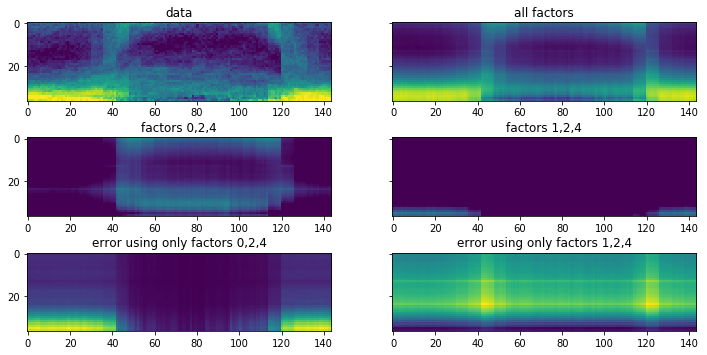

In [206]:
# Check low-rank and sparse component
fig,ax = plt.subplots(3,2,figsize=(12,6),sharey=True)
ax[0,0].imshow(sonar_tensor[recons_day,:,:],vmin=-76,vmax=-61)
ax[0,0].set_title('data')
ax[0,1].imshow(full_tensor_nonneg[recons_day,:]+sonar_tensor.min(),vmin=-76,vmax=-61)
ax[0,1].set_title('all factors')
ax[1,0].imshow(recons_vec_024.reshape((37,144))+sonar_tensor.min(),vmin=-76,vmax=-61)
ax[1,0].set_title('factors 0,2,4')
ax[1,1].imshow(recons_vec_124.reshape((37,144))+sonar_tensor.min(),vmin=-76,vmax=-61)
ax[1,1].set_title('factors 1,2,4')
ax[2,0].imshow(full_tensor_nonneg[recons_day,:]-recons_vec_024.reshape((37,144)))
ax[2,0].set_title('error using only factors 0,2,4')
ax[2,1].imshow(full_tensor_nonneg[recons_day,:]-recons_vec_124.reshape((37,144)))
ax[2,1].set_title('error using only factors 1,2,4')
plt.show()

### Check how factors look like

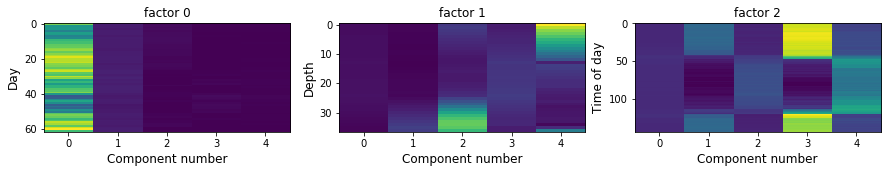

In [217]:
fig,ax = plt.subplots(1,3,figsize=(15,2))
for i in range(3):
    ax[i].imshow(factors_kruskal_noneg[i],aspect='auto')
    ax[i].set_title('factor %d' % i)
    ax[i].set_xlabel('Component number',fontsize=12)
    if i==0:
        ax[i].set_ylabel('Day',fontsize=12)
    elif i==1:
        ax[i].set_ylabel('Depth',fontsize=12)
    else:
        ax[i].set_ylabel('Time of day',fontsize=12)

- factor 0 is activation of each component along the day axis
- factor 1 is activation of each component along the depth axis
- factor 2 is activation of each component along the time-of-day axis

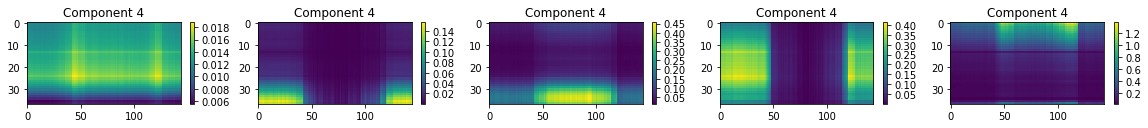

In [252]:
fac_num = kruskal_nonneg_rank
fig = plt.figure(figsize=(20,1.5))
for fac in range(fac_num):
    fig.add_subplot(1,fac_num,fac+1)
    plt.title('Component %d'% i)    
    plt.imshow(kh12_nonneg[:,fac].reshape(37,144),aspect='auto')
    plt.colorbar()

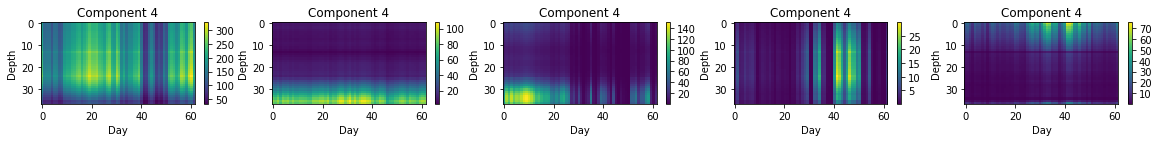

In [251]:
fac_num = kruskal_nonneg_rank
fig = plt.figure(figsize=(20,1.5))
for fac in range(fac_num):
    fig.add_subplot(1,fac_num,fac+1)
    plt.imshow(kh01_nonneg[:,fac].reshape(62,37).T,aspect='auto')
    plt.title('Component %d'% i)
    plt.xlabel('Day')
    plt.ylabel('Depth')
    plt.colorbar()

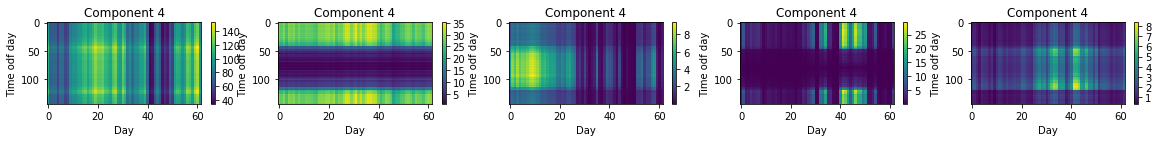

In [250]:
fac_num = kruskal_nonneg_rank
fig = plt.figure(figsize=(20,1.5))
for fac in range(fac_num):
    fig.add_subplot(1,fac_num,fac+1)
    plt.imshow(kh02_nonneg[:,fac].reshape(62,144).T,aspect='auto')
    plt.title('Component %d'% i)
    plt.xlabel('Day')
    plt.ylabel('Time odf day')
    plt.colorbar()

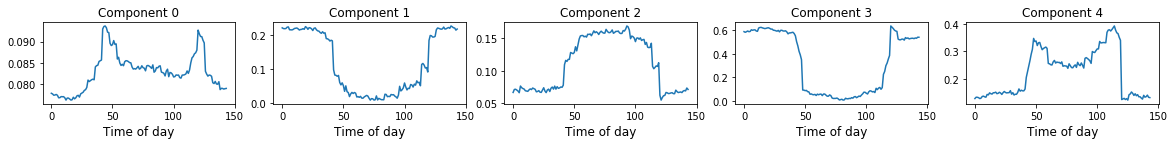

In [229]:
fig,ax = plt.subplots(1,5,figsize=(20,1.5))
for i in range(5):
    ax[i].plot(factors_kruskal_noneg[2][:,i],label=i)
    ax[i].set_title('Component %d'% i)
    ax[i].set_xlabel('Time of day',fontsize=12)
plt.show()

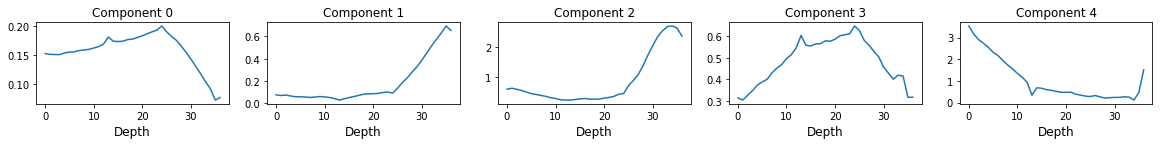

In [230]:
fig,ax = plt.subplots(1,5,figsize=(20,1.5))
for i in range(5):
    ax[i].plot(factors_kruskal_noneg[1][:,i],label=i)
    ax[i].set_title('Component %d'% i)
    ax[i].set_xlabel('Depth',fontsize=12)
plt.show()

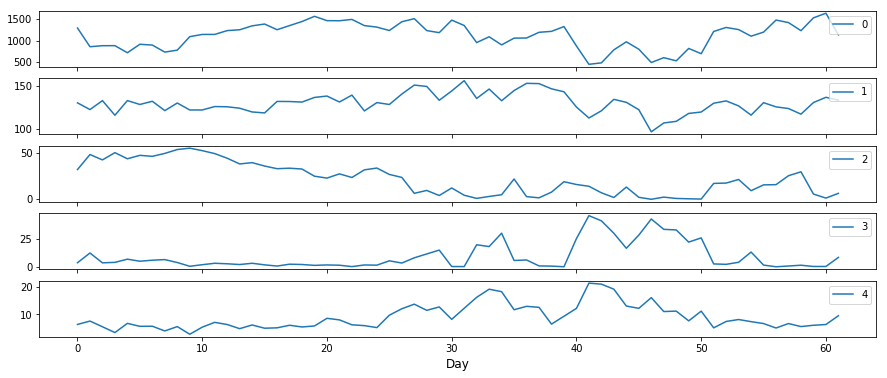

In [244]:
fig,ax = plt.subplots(5,1,figsize=(15,6),sharex=True)
for i in range(5):
    ax[i].plot(factors_kruskal_noneg[0][:,i],label=i)
    ax[i].legend(loc='upper right')
ax[i].set_xlabel('Day',fontsize=12)
plt.show()

In [ ]:
k = factors_kruskal_noneg[0].T
k_norm = k.T-k.min(axis=1)
k_norm = k_norm/k_norm.max(axis=0)
k_norm.shape

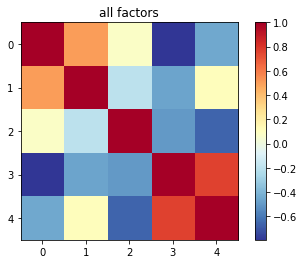

In [245]:
plt.imshow(np.corrcoef(k_norm.T),cmap='RdYlBu_r')
plt.colorbar()
plt.title('all factors')
plt.show()

### Number of component = 8

In [254]:
kruskal_nonneg_rank = 8
factors_kruskal_noneg = non_negative_parafac(sonar_tensor-sonar_tensor.min(), rank = kruskal_nonneg_rank)

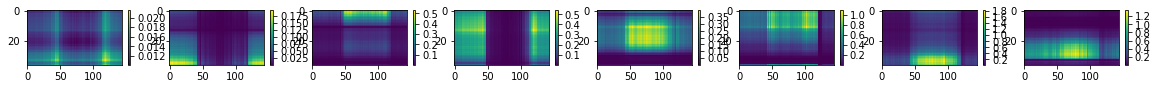

In [255]:
kh12_nonneg = khatri_rao((factors_kruskal_noneg[1],factors_kruskal_noneg[2]))
kh01_nonneg = khatri_rao((factors_kruskal_noneg[0],factors_kruskal_noneg[1]))
kh02_nonneg = khatri_rao((factors_kruskal_noneg[0],factors_kruskal_noneg[2]))

fac_num = kruskal_nonneg_rank
fig = plt.figure(figsize=(20,1))
for fac in range(fac_num):
    fig.add_subplot(1,fac_num,fac+1)
    plt.imshow(kh12_nonneg[:,fac].reshape(37,144),aspect='auto')
    plt.colorbar()

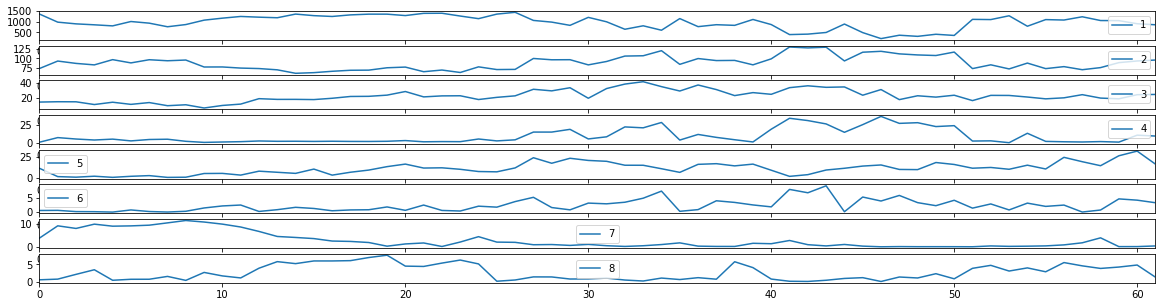

In [256]:
fig = plt.figure(figsize=(20,5))
for fac in range(fac_num):
    fig.add_subplot(fac_num,1,fac+1)
    plt.plot(factors_kruskal_noneg[0][:,fac],label='%d'% (fac+1))
    plt.xlim(0,61)
    plt.legend()
plt.show()

In [257]:
k = factors_kruskal_noneg[0].T
k_norm = k.T-k.min(axis=1)
k_norm = k_norm/k_norm.max(axis=0)
k_norm.shape

(62, 8)

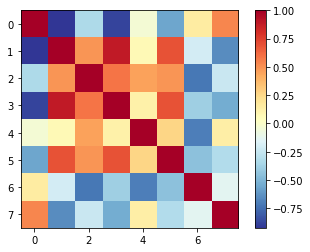

In [258]:
k = factors_kruskal_noneg[0]
plt.imshow(np.corrcoef(k_norm.T),cmap='RdYlBu_r')
plt.colorbar()
plt.show()

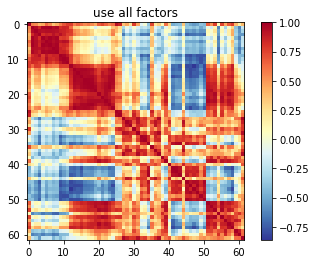

In [259]:
plt.imshow(np.corrcoef(k_norm),cmap='RdYlBu_r')
plt.colorbar()
plt.title('use all factors')
plt.show()

### Number of component = 10

In [278]:
kruskal_nonneg_rank = 6
factors_kruskal_noneg = non_negative_parafac(sonar_tensor-sonar_tensor.min(), rank = kruskal_nonneg_rank)

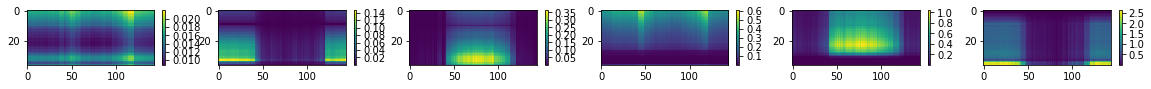

In [279]:
kh12_nonneg = khatri_rao((factors_kruskal_noneg[1],factors_kruskal_noneg[2]))
kh01_nonneg = khatri_rao((factors_kruskal_noneg[0],factors_kruskal_noneg[1]))
kh02_nonneg = khatri_rao((factors_kruskal_noneg[0],factors_kruskal_noneg[2]))

fac_num = kruskal_nonneg_rank
fig = plt.figure(figsize=(20,1))
for fac in range(fac_num):
    fig.add_subplot(1,fac_num,fac+1)
    plt.imshow(kh12_nonneg[:,fac].reshape(37,144),aspect='auto')
    plt.colorbar()

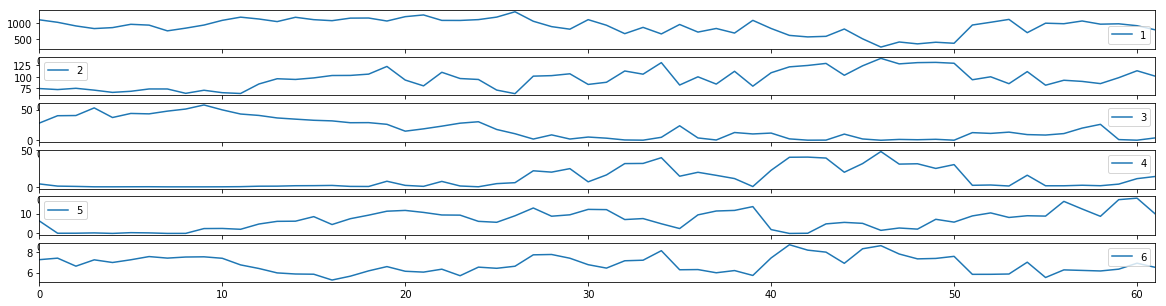

In [280]:
fig = plt.figure(figsize=(20,5))
for fac in range(fac_num):
    fig.add_subplot(fac_num,1,fac+1)
    plt.plot(factors_kruskal_noneg[0][:,fac],label='%d'% (fac+1))
    plt.xlim(0,61)
    plt.legend()
plt.show()

In [281]:
k = factors_kruskal_noneg[0].T
k_norm = k.T-k.min(axis=1)
k_norm = k_norm/k_norm.max(axis=0)
k_norm.shape

(62, 6)

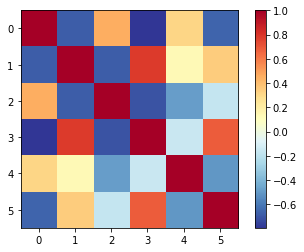

In [282]:
k = factors_kruskal_noneg[0]
plt.imshow(np.corrcoef(k_norm.T),cmap='RdYlBu_r')
plt.colorbar()
plt.show()

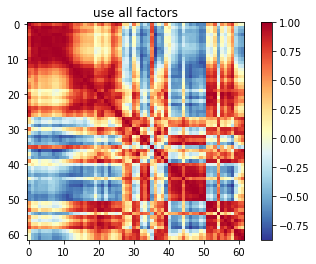

In [283]:
plt.imshow(np.corrcoef(k_norm),cmap='RdYlBu_r')
plt.colorbar()
plt.title('use all factors')
plt.show()

## Iterate number of components and check clusters across days

3
4
5
6
7
8
9
10


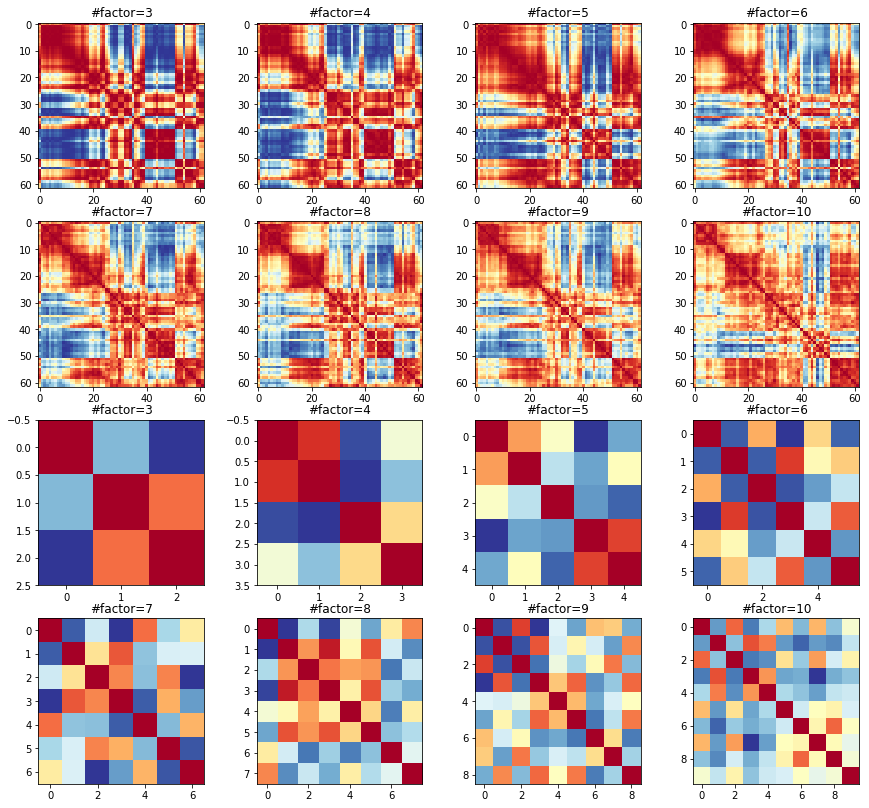

In [329]:
rank_all = np.arange(3,11,1)
fig,ax = plt.subplots(4,4,figsize=(15,14))
for r in rank_all:
    print(r)
    kruskal_nonneg_rank = r
    factors_kruskal_noneg = non_negative_parafac(sonar_tensor-sonar_tensor.min(), rank=kruskal_nonneg_rank)
    k = factors_kruskal_noneg[0].T
    k_norm = k.T-k.min(axis=1)
    k_norm = k_norm/k_norm.max(axis=0)
    i,j = np.divmod(r-rank_all[0],4)
    # Similarity between days
    ax[i,j].imshow(np.corrcoef(k_norm),cmap='RdYlBu_r')
    ax[i,j].set_title('#factor=%d'%r)
    # Similarity between component
    ax[i+2,j].imshow(np.corrcoef(k_norm.T),cmap='RdYlBu_r')
    ax[i+2,j].set_title('#factor=%d'%r)

### Check fit/error with different rank

(3, 1930740.659506361)
(4, 784258.5310179443)
(5, 764482.6285737788)
(6, 799374.372587129)
(7, 678947.8364552609)
(8, 660558.6165321193)
(9, 564952.8732995526)
(10, 550298.5452086021)


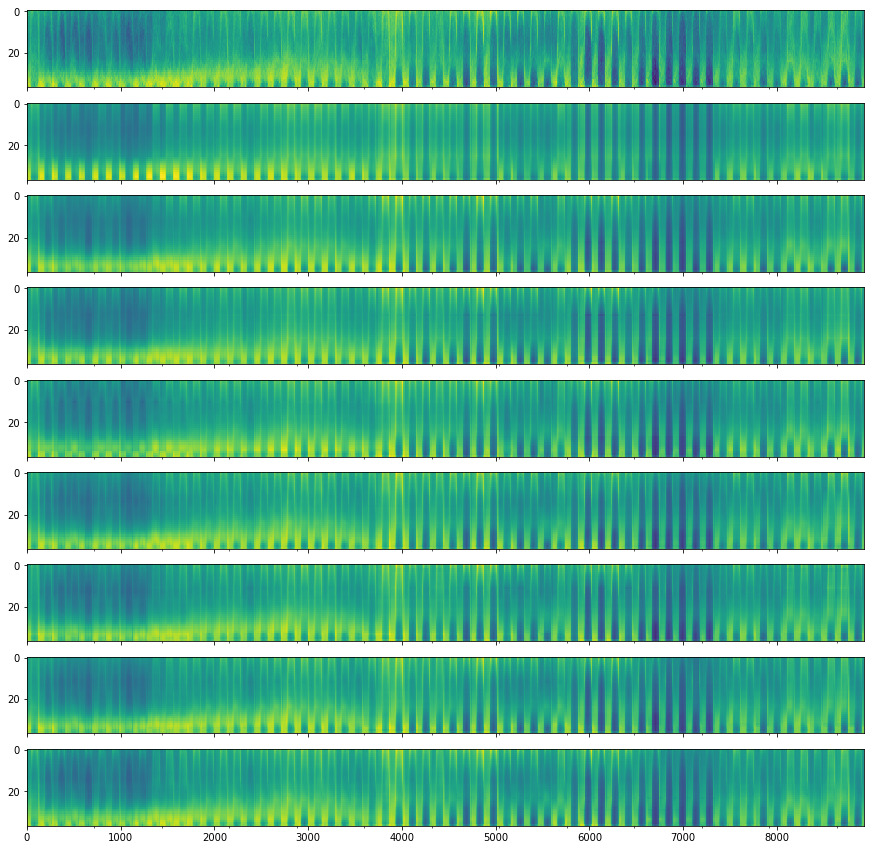

In [381]:
rank_all = np.arange(3,11,1)
e_all = []
fig,ax = plt.subplots(9,1,figsize=(15,15),sharex=True)
ax[0].imshow(tl.unfold(tl.tensor(sonar_tensor),mode=1), 
               aspect='auto', vmin=-97,vmax=-57)
ax[0].set_xticks(range(0,62*144,144*5), range(0,62,5))
for seq,r in enumerate(rank_all):
    kruskal_nonneg_rank = r
    factors_kruskal_noneg = non_negative_parafac(sonar_tensor-sonar_tensor.min(), rank=kruskal_nonneg_rank)
    full_tensor_nonneg = tl.kruskal_to_tensor(factors_kruskal_noneg)
    e = tl.unfold(tl.tensor(sonar_tensor-sonar_tensor.min()),mode=1)-tl.unfold(tl.tensor(full_tensor_nonneg),mode=1)
    print((r, np.sum(e**2)))
    e_all.append(np.sum(e**2))
    
    ax[seq+1].imshow(tl.unfold(tl.tensor(full_tensor_nonneg)+sonar_tensor.min(),mode=1), 
                   aspect='auto', vmin=-97,vmax=-57)
    ax[seq+1].set_xticks(range(0,62*144,144*5), range(0,62,5))
plt.show()

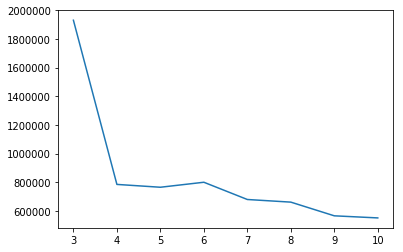

In [366]:
plt.plot(rank_all,np.array(e_all))

In [357]:
np.sum(e**2)

764482.628573645